# MLP for MNIST

*Note*: This notebook is **heavily** based on a [Deep Learning Udacity Notebook](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb). As a result many of the notes, comments, and code originate from there.

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

---

**Table of Contents:**

1. [Data](#data)
    1. [Prepare the data](#preparing-data)
    2. [Load the data and visualize the data](#vizualize-data)
2. [Architecture](#architecture)
    1. [Define a neural network architecture](#network-architecture)
    2. [Define a Loss function and optimizer](#loss-optimizer)
3. [Train the model + use validation](#train)
    * [Save the model](#save-load)
4. [Test the performance of the trained model](#test)
    - [See which things the model gets wrong](#visualize-test)
5. [Other Notes](#other-notes)
    1. [Transformers](#transformers)
    2. [DataLoader](#dataloader)
    3. [Autograd](#autograd)
    4. [CUDA](#cuda)

In [1]:
# import libraries
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
from datetime import datetime
import pickle
random_seed = 1

# print multiple outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

%matplotlib
%matplotlib inline


Using matplotlib backend: agg


In [2]:
# set everything up for development on GPU

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
device

# notice that tensor right now says that it is on cuda
assert(torch.rand(3,2).to(device).get_device() == 0)

<a id="data"></a>
## Data

---

<a id="preparing-data"></a>

### Preparing the Data

In [3]:
# number of subprocesses to use for data loading
num_workers = 3
# number of images to load per batch
batch_size = 32

# convert image to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<a id="visualize-data"></a>
### Visualize a Batch of Training Data

* Take a look at the data, make sure it is loaded in correctly.
* Try and spot some patterns, get familiar with the dataset.


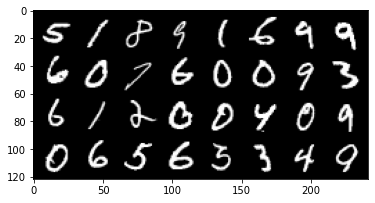



tensor([5, 1, 8, 9, 1, 6, 9, 9, 6, 0, 7, 6, 0, 0, 9, 3, 6, 1, 2, 0, 0, 4, 0, 9,
        0, 6, 5, 6, 3, 3, 4, 9])


In [4]:
def imshow(images, nrow=8):
    images = torchvision.utils.make_grid(images, nrow=nrow);
    npimg = images.numpy();
    plt.imshow(np.transpose(npimg, (1, 2, 0)));
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(images)
print(labels)


### View an Image in More Detail

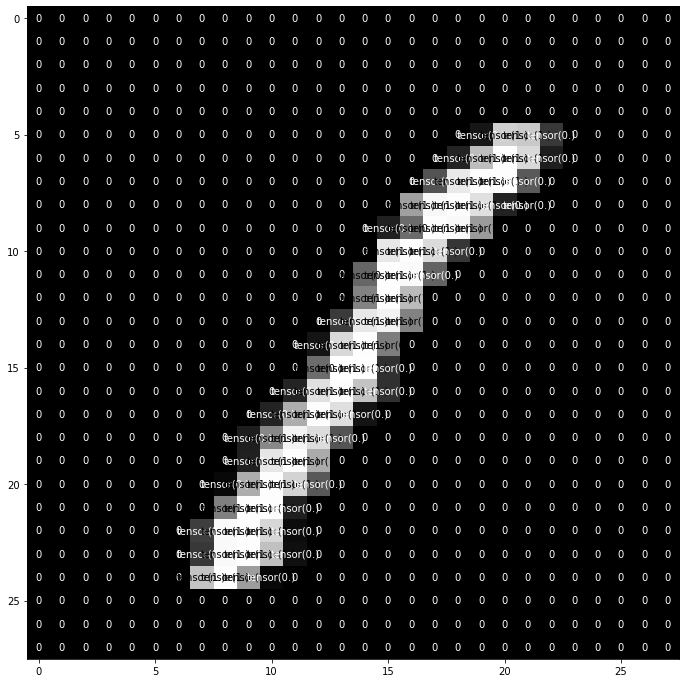

In [5]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = torch.round(img[x][y]) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

<a id="architecture"></a>
## Architecture

---

<a id="network-architecture"></a>
### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


The architecture will be responsible for taking 784-dimensional Tensor(where each one of the pixels is considered an initial feature), and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image.

- The nodes are what hold the actual data. First layer nodes will hold the initial inputs as features, and later layer nodes will represent more and more abstract features that the network learns based on combinations of features from previous layeres
- Layers (the ones in init) apply a specific transformation to the inputs. For example a linear transformation `nn.Linear(inputs, outputs)` will apply the equation $y=x*W^T+b$ to the transformation.


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, num_features_in, num_features_out):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (num_features_in -> hidden_1)
        self.fc1 = nn.Linear(num_features_in, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, num_features_out)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net(28*28,10).to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


<a id="loss-optimizer"></a>
###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [7]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

<a id="train"></a>
## Train the Network

---

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: Based on the loss, do backpropagation and calculate the gradient, i.e compute gradient of the loss with respect to model parameters
5. Update the weights: Perform a single optimization step (parameter update)
6. Update average training loss

* Notice how values for training loss decrease over time.
* Want it to keep decreasing whilst at the same time avoiding overfitting the data

In [8]:
# number of epochs to train the model
n_epochs = 3
train_losses = []

In [9]:
model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # clear the gradients from its state(all optimized variables)
        optimizer.zero_grad()
        # forward pass: compute the predictions by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to each one of the model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Add running training loss
        train_loss += loss.item()*data.shape[0]
             
    # average train loss running training loss(loss1*len(batch1)+..+lossn*len(batchn))/num_imgs
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch+1} Training Loss: {round(train_loss,4)}")

Epoch: 1 Training Loss: 1.0856
Epoch: 2 Training Loss: 0.3878
Epoch: 3 Training Loss: 0.3141


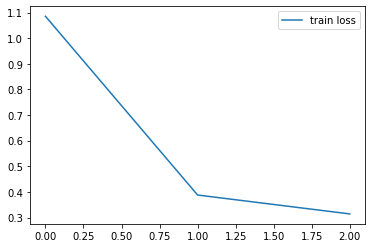

In [10]:
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.legend()
plt.show()

<a id="save-load"></a>
### Saving and Loading a model

* This step is optional, however it makes sure that the data of your model is saved in a format which you can easily retrieve later on, instead of having to retrain your model.
* Also helps if you're training your network online, somewhere where the kernel can be interrupted due to inactivity(like kaggle), in which case saving it at the end will guarantee it a persistent place.
* **Loading**: When you're loading a state dict into a model, the model has to have the same shapes as the saved state_dict, i.e **you cannot alter the model architecture** after you've saved it.


In [11]:
def save_checkpoint(model, optimizer, epoch,path='/kaggle/working/', f_name='checkpoint'):
    '''Here\'s the following information we need to save an intermediary
    checkpoint from which we can resume later on:
    1. Model parameters. These are the things that are being optimized in training,
    so we definitely want to save them and resume from them
    2. The optimizer also has its own parameters depending on the optimizer: learning rate, momentum, beta, etc.
    If you want to continue using the same optimizer, you need to save its parameters.
    Some optimizers like Adam, have adaptive parameters(learning rate), so you need to save a snapshot of it,
    just like you would save a snapshot of the model parmaeters, if you want to continue training **exactly** from
    the moment you left off
    '''
    checkpoint = {
    'network_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'epoch': epoch
    }
    full_name = path + f_name + '.th'
    torch.save(checkpoint, full_name)

def load_checkpoint(model, optimizer, path='/kaggle/working/', f_name='checkpoint'):
    '''Example of loading it:
    Make sure model and optiizer are the same
    model = Net(784, 10)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    load_checkpoint(model, optimizer)
    '''
    full_name = path + f_name + '.th'
    checkpoint = torch.load(full_name)
    model.load_state_dict(checkpoint['network_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    epoch = checkpoint['epoch']
    return epoch

In [12]:
save_checkpoint(model, optimizer, epoch)

<a id="test"></a>
## Test the Trained Network

---

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [13]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.shape[0]
        # convert output probabilities to predicted class
        pred = torch.argmax(output,1)
        # compare predictions to true label
        correct = pred.eq(target)
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print(f"Test Loss: {round(test_loss,6)}\n")

for i in range(10):
    if class_total[i] > 0:
        print(f"Test Accuracy of {round(i,5)}:\
              {round(100 * class_correct[i] / class_total[i],2)}%\
              {round(np.sum(class_correct[i]),2)}/{round(np.sum(class_total[i]),2)}")

    else:
        print(f"Test Accuracy of {round(classes[i],5)}: N/A (no training examples)")

print(f"Test Accuracy (Overall): {round(100. * np.sum(class_correct) / np.sum(class_total),2)}% {round(np.sum(class_correct),2)}/{round(np.sum(class_total),2)}")

Test Loss: 0.255297

Test Accuracy of 0:              98.47%              965.0/980.0
Test Accuracy of 1:              97.53%              1107.0/1135.0
Test Accuracy of 2:              88.86%              917.0/1032.0
Test Accuracy of 3:              90.89%              918.0/1010.0
Test Accuracy of 4:              94.91%              932.0/982.0
Test Accuracy of 5:              89.46%              798.0/892.0
Test Accuracy of 6:              94.68%              907.0/958.0
Test Accuracy of 7:              93.29%              959.0/1028.0
Test Accuracy of 8:              87.99%              857.0/974.0
Test Accuracy of 9:              88.5%              893.0/1009.0
Test Accuracy (Overall): 92.53% 9253.0/10000.0


<a id="vizualize-test"></a>
#### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

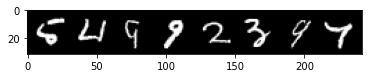

correct classes are:['5', '4', '9', '9', '2', '3', '9', '7']
predicted classes are:['6', '6', '4', '7', '7', '5', '4', '4']


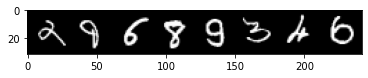

correct classes are:['2', '9', '6', '8', '9', '3', '4', '6']
predicted classes are:['9', '4', '5', '7', '8', '5', '2', '0']


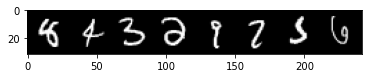

correct classes are:['8', '4', '3', '2', '9', '2', '5', '6']
predicted classes are:['4', '6', '5', '3', '7', '7', '3', '4']


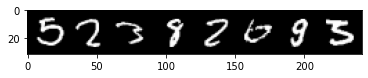

correct classes are:['5', '2', '3', '8', '2', '6', '9', '3']
predicted classes are:['0', '7', '7', '7', '8', '0', '8', '5']


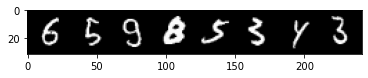

correct classes are:['6', '5', '9', '8', '5', '3', '4', '3']
predicted classes are:['5', '8', '3', '0', '3', '5', '8', '6']


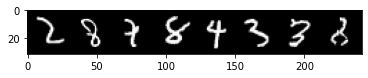

correct classes are:['2', '8', '7', '8', '4', '3', '3', '8']
predicted classes are:['1', '3', '1', '6', '9', '5', '2', '2']


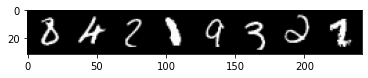

correct classes are:['8', '4', '2', '1', '9', '3', '2', '2']
predicted classes are:['3', '6', '8', '8', '4', '9', '6', '9']


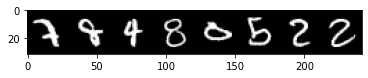

correct classes are:['7', '8', '4', '8', '0', '5', '2', '2']
predicted classes are:['3', '4', '9', '5', '6', '8', '8', '8']


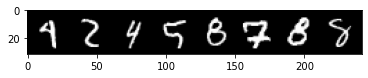

correct classes are:['4', '2', '4', '5', '8', '7', '8', '8']
predicted classes are:['9', '8', '9', '9', '5', '2', '3', '7']


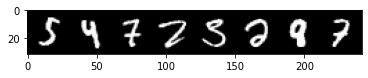

correct classes are:['5', '4', '7', '2', '3', '2', '8', '7']
predicted classes are:['3', '9', '2', '7', '5', '0', '9', '2']


In [14]:
# get a batch of examples
model.eval()
num_per_group = 8
num_groups_to_show=10
total_mislabeled_images = []
total_actual_classes = []
total_predicted_classes = []
for data, target in test_loader:
    images, labels = data.to(device), target.to(device)

    # pass it through the model, and get the predictions
    predictions = model(images)
    predictions = torch.argmax(predictions,dim=1)

    # get list of classes
    images = images.to('cpu')
    labels = labels.to('cpu')
    predictions = predictions.to('cpu')

    # analyse
    classes = np.array(test_data.classes)
    actual_classes = classes[labels]
    predicted_classes = classes[predictions]
    # curr format is 0-zero. Get only the 0 char
    actual_classes = np.array([el[0] for el in actual_classes])
    predicted_classes = np.array([el[0] for el in predicted_classes])

    wrong_indices = np.where(predicted_classes != actual_classes)
    mislabeled_images = images[wrong_indices]
    
    
    # aggregate everything
    total_mislabeled_images.append(mislabeled_images.numpy())
    total_actual_classes.extend(actual_classes[wrong_indices])
    total_predicted_classes.extend(predicted_classes[wrong_indices])

# display results
total_mislabeled_images = np.vstack(np.array(total_mislabeled_images))
num_splits = total_mislabeled_images.shape[0] // num_per_group
mislabeled_list = np.split(total_mislabeled_images[:num_splits*num_per_group],num_splits)
count = 0
for group in mislabeled_list:
    group = torch.Tensor(group)
    imshow(group);
    print("correct classes are:" + str(total_actual_classes[count*num_per_group:(count+1)*num_per_group]));
    print("predicted classes are:" + str(total_predicted_classes[count*num_per_group:(count+1)*num_per_group]));
    count+=1
    if(count == num_groups_to_show):
        break

<a id="other-notes"></a>
## Other Notes

---

<a id="transformers"></a>
### Transformers

These are common image transformations. *They are chained together using `Compose`*

Example:
```python

    transformer = transforms.Compose([
        transforms.CenterCrop(10),
        ..., # any other relevant transforms
        transforms.ToTensor(), # Mandatory!!! always add this at the end
        transforms.Normalize() # Mandatory!!!

    ])
```

<mark>*Note*: Always use a `transforms.ToTensor()` at the end to convert to a tensor(default unit in Pytorch), and use a `transforms.Normalize` to normalize your tensor.</mark>

#### Transformer examples

* `transforms.Resize`: resize input PIL to given size
* `transforms.CenterCrop`: crops a PIL image at the center
* `transforms.ColorJitter`: randomly change brigthness, contrast and saturation of an image 
* `transforms.FiveCrop`: crops given PIL image into 4 cournes and 1 central crop, essentially creating 5 different images. 
* `transforms.GrayScale`: convert to grayscale
* `transforms.RandomCrop`: crop given PIL image at random location
* `transforms.RandomHorizontalFlip/RandomVerticalFlip`: randomly flip horizontally/vertically
* `transforms.RandomRotation`: rotate the image by a random angle




#### Impact of transforms on dataset size

[Relevant link](https://discuss.pytorch.org/t/how-to-increase-number-of-images-with-data-augmentation/45795)

**Note**: transforms don't actually increase the size of your dataset, *however*, **they apply the series of transformatiosn** to every image in a batch, therefore, every time you run the same batch, you will actually get a different set of images. This means that to train your network on more images, simply increase the number of epochs(i.e train it for longer), as the same batch will yield different images every time it's run, and therefore more training data for the network!.


#### Normalizing a transformer


##### Why

By keeping the network inputs close to 0, normalization makes the training process *a lot faster*. [More in-depth explanation](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn)


###### How

From [InnovArul](https://discuss.pytorch.org/t/understanding-transform-normalize/21730):

>
>Normalize does the following for each channel:
>
>image = (image - mean) / std
>
>The parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be >converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.
>
>if you would like to get your image back in [0,1] range, you could use,
>
>image = ((image * std) + mean)


<a id="dataloader"></a>
### DataLoader


* Get data in a format that you can use in Pytorch
* Get an iterator for the data. `DataLoader` class is perfect for this. You could just iterate through the data by yourself, but using the DataLoader allows you to very easily select different properties like:
    * The batch size, i.e how many images or pieces of data you will train your network on in one forward pass. You don't want to train it on **all** of your data since that will be very computationally heavy, both to do a forward pass, and then respectively a backward one, since you will have to calculate the gradient for much bigger matrices(#TODO: why?). Therefore, we choose a batch size that allows computational efficiency.
    * shuffle: you can easily shuffle all of the images in each batch before you iterate through it. #TODO:explain why
    * drop_last: drop the last batch if incomplete
    * many others


#### Speeding Up DataLoader

From: [pytorch forum 1](https://discuss.pytorch.org/t/why-is-pytorchs-gpu-utilization-so-low-in-production-not-training/38366/4
),[pytorch forum 2](https://discuss.pytorch.org/t/gpu-not-fully-used/34102/3) :
> If you set pin_memory=True in your DataLoader the data in your Dataset will be loaded into pinned host memory, which makes the transfer to the device faster. Have a look at NVIDIA’s blog post 41 about this topic.


* A lot of the times during training, the dataloader seems to take a lot more time than the forward pass.
* Here's some things to do to speed things up:
    * Add: `pin_memory = True` to dataloader, and `non_blocking = True` to tensor that's getting data from dataloader
    * Add `non_blocking=True` to the tensor.to(). Have to be careful here, cause it's a bit of a tradeoff since an increase in num_workers will increase RAM. so find a good number from experimentation.
    * Another option, though think about it carefully, is to not shuffle the data, i.e `shuffle=False`



<a id="autograd"></a>
### Autograd

Before we start, here are some explanations of autograd

* A Neural Network does a forward pass, which means it just goes through its architecture, multiplying inputs from the previous layer by weights of current layer, adding bias, modifying result with an activation function to create non-linearity and get the result in a certain range and distribution. This result is then used as the input for the next layer, and on it goes until we reach the final layer. Once we get to the final layer, we calculate the loss function(a function which quantifies the difference between a network's predictions and target values(what it should have predicted if it was an expert). 
* Once a forward pass is made,i.e a neural network spits out predictions and we calculate the loss for them, Neural network weights are adjusted through backpropagation to **minimize the difference**(loss) between the predictions and correct values.
* Backpropagation, is essentially just chain rule. Gradients are calculated by traversing the graph from the loss to every leaf in the network and multiply every gradient in the way using chain rule [$^1$](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95#:~:text=is%20not%20needed.-,Backward()%20function,gradients%20are%20then%20stored%20in%20.)
* Pytorch creates the graph at every iteration(when you do a forward pass). Therefore, this allows you to modify the architectures on the go.[$^2$](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95#:~:text=is%20not%20needed.-,Backward()%20function,gradients%20are%20then%20stored%20in%20.)
* Each weight and bias in the network is a [Tensor](https://pytorch.org/docs/stable/tensors.html), which has a `.requires_grad` property. When you set the property to `True` it becomes part of a graph with all of the tensors that it interacts with (through various operations), and stores the operation that was called on it, so that pytorch can then know how to differentiate. The *Autograd* package, the one that does differentiation, can differentiate pretty much all functions, so any function encountered in the `.grad_fn` of the tensor is doable for it. When you define a model using a `nn.Module` class, the `.requires_grad` is automatically set for you.
* Therefore, once `.backward()` is called, the gradient is calculated from the loss all the way to each weight and stored, in the `.grad` property of each tensor. If you don't want a tensor being tracked(i.e it won't store what operations it was produced from), you[](http://) can just call `.detach()` on it, or wrap the code block(where you do the backward pass) with `torch.no_grad()`.

In [15]:
import torch.nn.functional as F

a = torch.rand(3,2)
a.requires_grad = True
print("a is: ", a)
print("a grad is: ", a.grad)
b = torch.rand(3,2)
b.requires_grad = True
c = 3*a + 2*b
d = c.sum() * 4
print("b is", b)
print("b grad is: ", b.grad)
print("c is",c)
print("c grad is: ", c.grad)
print("d is", d)
print("d grad is: ", d.grad)
d.backward()
print("performing backward pass, which will save gradients")
print("a grad is: ", a.grad)
print("b grad is: ", b.grad)
print("c grad is: ", c.grad)
print("d grad is: ", d.grad)
print('-------------------')
print("with history enabled")
print(a **2)
print("with history disabled, notice tensor has no information on its creation\
      , tensors involved in it")
with torch.no_grad():
    print(a ** 2)

a is:  tensor([[0.0781, 0.7081],
        [0.7764, 0.6055],
        [0.5953, 0.8248]], requires_grad=True)
a grad is:  None
b is tensor([[0.6863, 0.0383],
        [0.5153, 0.2158],
        [0.2607, 0.4578]], requires_grad=True)
b grad is:  None
c is tensor([[1.6071, 2.2009],
        [3.3599, 2.2480],
        [2.3074, 3.3902]], grad_fn=<AddBackward0>)
c grad is:  None
d is tensor(60.4536, grad_fn=<MulBackward0>)
d grad is:  None
performing backward pass, which will save gradients
a grad is:  tensor([[12., 12.],
        [12., 12.],
        [12., 12.]])
b grad is:  tensor([[8., 8.],
        [8., 8.],
        [8., 8.]])
c grad is:  None
d grad is:  None
-------------------
with history enabled
tensor([[0.0061, 0.5014],
        [0.6028, 0.3666],
        [0.3544, 0.6804]], grad_fn=<PowBackward0>)
with history disabled, notice tensor has no information on its creation      , tensors involved in it
tensor([[0.0061, 0.5014],
        [0.6028, 0.3666],
        [0.3544, 0.6804]])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  app.launch_new_instance()
/opt/conda/lib/

<a id="cuda"></a>
## Using CUDA

* Tensors are data structures, so they have to be stored somewhere on your PC. They are by default stored on the *cpu*. However, we know that gpus are **much** faster at parallel computations, therefore we want to store them on GPU's, which will make any operations on them perform *much*,*much faster*. 

### Basic rules of devices

* Tensors **must be on same device** to do an operation(multiplication, subtraction, etc) on them. 
* If an operation between tensors(addition, etc) results in a new tensor, the **new tensor will be stored on same device as the original tensors**. Therefore if `c = a + b`, then c will be on same device as a and b are. This means you don't need to manually move it to the device you intend to use, unless you need to change it. 

### Moving tensor to another device(cpu, gpu, etc)

*Following is heavily inspired from: https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09*

* Since tensors are stored by default on the *cpu*, you always have to move them over to the *gpu* if you intend to use it.
* Every tensor in pytorch has a `to()` function, which it uses to put the tensor on a certain device, i.e CPU or specific GPU [$^2$](https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09): `el = torch.rand(3,2).to(device)`
* You can create the device with a string *cpu* or *cuda:0*, based on the avaialability:
    ```
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    device = torch.device(dev)
    ```
* **You can also put the whole network on cuda, since <mark>`nn.module`(the class that your network **has** to inherit) has a `to` and `cuda` function</mark>**

### What do you move to cuda

Short, answer everything. You want to move all of your tensors to CUDA to take full advantage of the GPU, also because you can't really do operations between 2 tensors if 1 of them is on one device(cpu, or a specific gpu), and second tensor is on a completely different device.

More specifically, you want to move:
* Entire network, which is done easily with `net = Network().to(device)`
* All of the data you use to *train* and *evaluate* the network on: `images = images.to(device)`

### Important methods:

> For more methods, go here: [pytorch documentation](https://pytorch.org/docs/stable/cuda.html)
* `torch.cuda.is_available()`: test for working install of nvidia with cuda
* `device  = torch.device('cpu'/'cuda:0')`: create the device you want(cpu, gpu, etc)
* `a_tensor.to(device)`: move tensor to specific device
* `tensor.get_device()`: get the tensor the device is running on